In [1]:
import torch
import torchvision.transforms as transforms
import time
import numpy as np
import pandas as pd
import os 
import ast
from usflc_xai import models, datasets

from LIME_custom_pipeline import LIME_subj_pipeline

In [2]:
def subj_pred_func(img_id_list):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    test_data_id = '09'
    metadata_name = 'meta_data/TWB_ABD_expand_modified_gasex_21072022.csv'
    test_data_list_name = 'fattyliver_2_class_certained_0_123_4_20_40_dataset_lists/dataset'+str(test_data_id)+'/test_dataset'+str(test_data_id)+'.csv'
    ckpt_name = 'model_tl_twbabd'+str(test_data_id)+'/best_r`esults.ckpt'
    image_encoder_id = 'densenet121'
    graph_encoder_id = 'SETNET_GAT'
    num_classes = 2
    input_dim = 1024
    num_layers = 1
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    meta_data = pd.read_csv(metadata_name, sep=",")
    test_data_list = pd.read_csv(test_data_list_name)
    mi_id = test_data_list['MI_ID'][0]
    
    ## Call pretrained image encoder ###
    _, pretrained_image_encoder = models.image_encoder_model(name=image_encoder_id, 
                                                pretrained=True, 
                                                num_classes=num_classes, 
                                                device=device)
    pretrained_image_encoder = pretrained_image_encoder.eval() 
    ### Call graph encoder ###
    graph_encoder, _=models.encoder_model(name=graph_encoder_id, 
                                        input_dim=input_dim,
                                        num_layers=num_layers,
                                        num_classes=num_classes,
                                        device=device)
    ### Load trained weights ###
    checkpoint = torch.load(ckpt_name)
    graph_encoder.load_state_dict(checkpoint['model_state_dict'])
    graph_encoder = graph_encoder.eval()
    

    y = meta_data[meta_data['MI_ID']==mi_id]['liver_fatty'].to_list()[0]
    ### Create graph data using image features ###
    mydata=datasets.single_data_loader(mi_id=mi_id,
                                    img_id_list=img_id_list,
                                    image_transform=transform,
                                    pretrained_image_encoder=pretrained_image_encoder,
                                    y=y,
                                    num_classes=num_classes,
                                    device=device)
    ### Classification ###
    x = mydata.x.to(device)
    y = mydata.y
    A = mydata.edge_index_corr.to(device)
    b = torch.zeros(x.shape[0], dtype=torch.int64).to(device)
    train_mask=1 
    h = graph_encoder(x, A, b, train_mask)
    _, y_hat = torch.max(h, dim=1)
    y_hat = y_hat.data.to('cpu').numpy()[0]
    
    return int(y_hat)

In [3]:
test_data_id = '09'
metadata_name = 'meta_data/TWB_ABD_expand_modified_gasex_21072022.csv'
test_data_list_name = 'fattyliver_2_class_certained_0_123_4_20_40_dataset_lists/dataset'+str(test_data_id)+'/test_dataset'+str(test_data_id)+'.csv'
test_data_list = pd.read_csv(test_data_list_name)
meta_data = pd.read_csv(metadata_name, sep=",")

## Subject id in the test data ##
mi_id = test_data_list['MI_ID'][0]
## Obtain image ids and label y for each subject. ###
img_id_list = ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])
y = 1
print(mi_id, img_id_list)

P0012750 ['IMG0001', 'IMG0002', 'IMG0003', 'IMG0004', 'IMG0005', 'IMG0006', 'IMG0007', 'IMG0008', 'IMG0009', 'IMG0010', 'IMG0011', 'IMG0013', 'IMG0014', 'IMG0016', 'IMG0018', 'IMG0021', 'IMG0022', 'IMG0023', 'IMG0024', 'IMG0025', 'IMG0026', 'IMG0027', 'IMG0029', 'IMG0030', 'IMG0032']


In [4]:
img_filenames = [str(mi_id)+'_'+str(i)+'.jpg' for i in img_id_list]
samples_class = LIME_subj_pipeline(test_data_id = '09', 
                                   img_list = img_id_list,
                                   mi_id = mi_id,
                                   img_dir = os.getenv('CROP_IMAGE_DIR_PATH'),
                                   pred_func = subj_pred_func,
                                   verbose = True,
                                   image_based = True,
                                   y = y,
                                   result_parent_dir = "/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results",
                                   )
samples_ = samples_class.predict_on_random_samples_until_convergence(n_samples = 100, 
                                                                     target_positive_proportion = 0.5, 
                                                                     min_sample_size = 3,
                                                                     max_sample_size = len(img_id_list),
                                                                     )
print(samples_[:3])

100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Accuracy on all single images: 0.68, # correct: 17, total # of imgs: 25
Enough positive samples 50, using negative sampling pool to increase negative samples


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]

Appending 50 samples to 50 samples
Appending 50 sample prediction results to 50 sample prediction results
number of total samples: 100 Final positive proportion: 0.6000
[array(['IMG0029', 'IMG0026', 'IMG0004', 'IMG0016', 'IMG0008'], dtype='<U7'), array(['IMG0005', 'IMG0029', 'IMG0021', 'IMG0018', 'IMG0016', 'IMG0008',
       'IMG0023', 'IMG0010', 'IMG0007', 'IMG0027', 'IMG0001', 'IMG0025',
       'IMG0022', 'IMG0013', 'IMG0009'], dtype='<U7'), array(['IMG0025', 'IMG0009', 'IMG0014', 'IMG0008'], dtype='<U7')]


In [5]:
print(np.unique(samples_class.sample_pred_results), 
      sum(samples_class.sample_pred_results), 
      len(samples_class.sample_pred_results), 
      sum(samples_class.sample_pred_results)/len(samples_class.sample_pred_results))

[0 1] 60 100 0.6


In [6]:
samples_class.get_imgs_marginal_relation(corr_type='pearson')

{0: {'corr': 0.48479484492583735,
  'corr_std': 0.08835075957617497,
  'corr_CI': (0.39644408534966236, 0.5731456045020124),
  'corr_upper_CI': 0.5731456045020124,
  'corr_lower_CI': 0.39644408534966236,
  'corr_p_val': 3.200307819358322e-07},
 1: {'corr': -0.16628325997832613,
  'corr_std': 0.09960892291863217,
  'corr_CI': (-0.2658921828969583, -0.06667433705969396),
  'corr_upper_CI': -0.06667433705969396,
  'corr_lower_CI': -0.2658921828969583,
  'corr_p_val': 0.09823739847573522},
 2: {'corr': -0.31544663407202245,
  'corr_std': 0.09585775074603033,
  'corr_CI': (-0.41130438481805276, -0.21958888332599213),
  'corr_upper_CI': -0.21958888332599213,
  'corr_lower_CI': -0.41130438481805276,
  'corr_p_val': 0.0013894069183829347},
 3: {'corr': -0.3061862178478973,
  'corr_std': 0.096163657270259,
  'corr_CI': (-0.4023498751181563, -0.2100225605776383),
  'corr_upper_CI': -0.2100225605776383,
  'corr_lower_CI': -0.4023498751181563,
  'corr_p_val': 0.001947430645523739},
 4: {'corr': -0

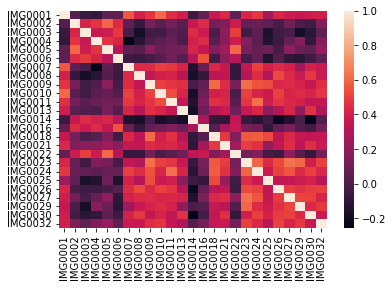

In [7]:
samples_class.plot_sampling_corr_heatmap()

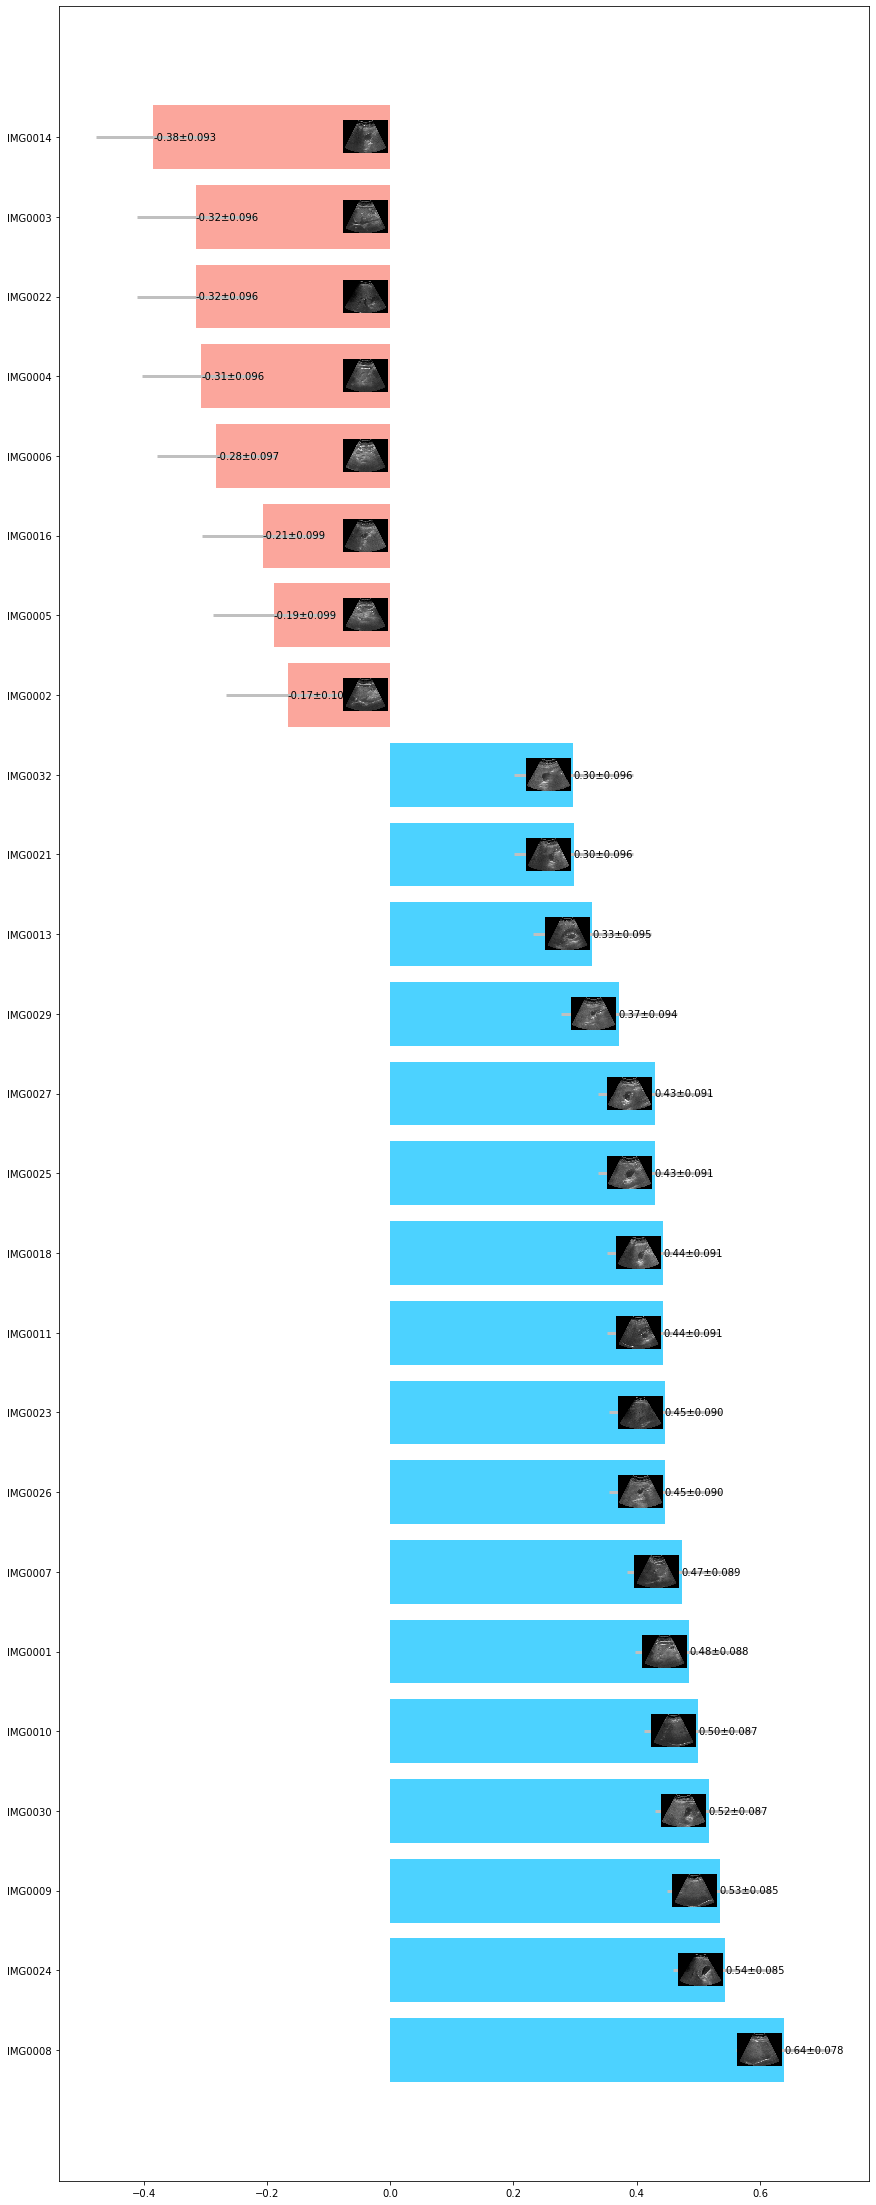

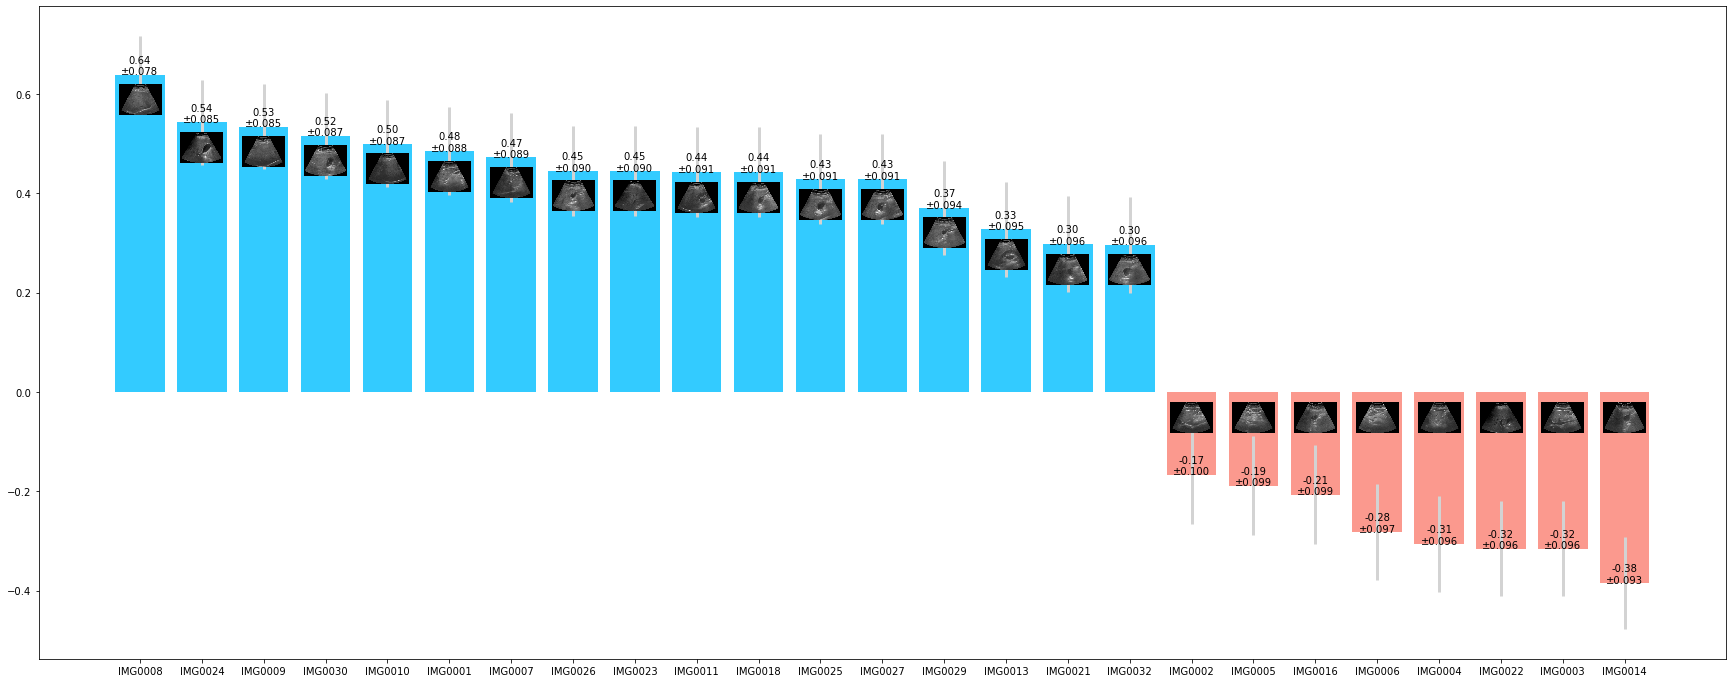

In [8]:
samples_class.plot_image_bar_plot()

In [9]:
samples_class.save_results()

In [ ]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import matthews_corrcoef
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.cbook as cbook
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,40)) 

def offset_image(x, y, img_path, bar_is_too_short, ax, zoom=0.06, vertical=False):
    img = plt.imread(img_path)
        
    im = OffsetImage(img, zoom=zoom, cmap='gray')
    im.image.axes = ax
    
    if vertical:
        # if y >= 0:
        #     xybox = (0, 10)  # Offset above the bar for positive values
        # else:
        #     xybox = (0, -10)  # Offset below the bar for negative values
            
        if bar_is_too_short:
            y = 0
        # y_offset = -25 if y >= 0 else 25  # Adjust offset based on bar direction
        y_offset = -25
        xybox = (0, y_offset)
    else:
        if bar_is_too_short:
            x = 0
        x_offset = -25 if x >= 0 else 25  # Adjust offset based on bar direction
        xybox = (x_offset, 0)
        
    # print(x, y)
    ab = AnnotationBbox(im, (x, y), xybox=xybox, frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)

    ax.add_artist(ab)

labels = samples_class.img_list.copy()
values = [samples_class.indx_to_corr[samples_class.img_to_indx[i]] 
            for i in labels
            ]

label_val = [(val, label) for val, label in sorted(zip(values, labels), 
                                        key = lambda pair: pair[0], 
                                        reverse= True)]
values, labels = zip(*label_val)
del label_val

colors = ["deepskyblue" 
            if val > 0 
            else "salmon" 
            for val in values]

zoom = 0.065
# if len(values) >= 22:
#     zoom = 0.06
# elif 22 > len(values) >= 10:
#     zoom = 0.08
# else:
#     zoom = 0.15

height = 0.8

stds = None
if None not in set(samples_class.indx_to_corr_std.values()):
    stds = [samples_class.indx_to_corr_std[samples_class.img_to_indx[i]] for i in labels]
    bar_labels = [f"{values[indx]:.2f}±{std:.3f}" for indx, std in enumerate(stds)]
    
    for indx, val in enumerate(values):
        plt.text(val, indx, bar_labels[indx], 
                #  ha='center', 
                 va='center',
                 )
else:

    for indx, val in enumerate(values):
        plt.text(val, indx, f"{val:.2f}", 
                #  ha='center', 
                 va='center',
                 )
        

plt.barh(y=labels, width=values, 
         height=height, color=colors, 
         align='center', alpha=0.7, 
         xerr = stds, ecolor='lightgray',
         error_kw=dict(lw=3,),)

if isinstance(values, np.ndarray):
    max_value = values.max()
elif isinstance(values, (list, tuple, set)):
    max_value = max(values)
    
ax = plt.gca()
for _, (label, value) in enumerate(zip(labels, values)):
    img_indx = samples_class.img_to_indx[label]
    img_abs_filepath = samples_class.indx_to_abs_filepath[img_indx]
    offset_image(x = value, 
                    img_path = img_abs_filepath, 
                    y = label, 
                    bar_is_too_short=value < max_value / 10, 
                    zoom=zoom,
                    ax=ax,)
plt.subplots_adjust(left=0.15)
plt.savefig(os.path.join(samples_class.result_dir,
                f"hbar.png"))
plt.show()

fig_width = len(labels) + len(labels)/4
fig_height = len(labels) // 2
plt.figure(figsize=(fig_width,fig_height))        

stds = None
if None not in set(samples_class.indx_to_corr_std.values()):
    stds = [samples_class.indx_to_corr_std[samples_class.img_to_indx[i]] for i in labels]
    bar_labels = [f"{values[indx]:.2f}\n±{std:.3f}" for indx, std in enumerate(stds)]
    
    for indx, val in enumerate(values):
        plt.text(indx, val, 
                 bar_labels[indx],
                 ha='center', 
                 ) 
else:

    for indx, val in enumerate(values):
        plt.text(indx, val, 
                 f"{val:.2f}",
                 ha='center', 
                 ) 

zoom = 0.25 / 4
plt.bar(x=labels, height=values, 
        width=0.8, color=colors, 
        align='center', alpha=0.8, 
        yerr=stds, ecolor='lightgray', 
        error_kw=dict(lw=3,),)
ax = plt.gca()
    
for _, (label, value) in enumerate(zip(labels, values)):
    img_indx = samples_class.img_to_indx[label]
    img_abs_filepath = samples_class.indx_to_abs_filepath[img_indx]
    offset_image(y = value, img_path = img_abs_filepath, 
                    x = label, 
                    bar_is_too_short=value < max_value / 10, 
                    ax=ax, 
                    zoom=zoom, 
                    vertical=True)
plt.subplots_adjust(left=0.15)
plt.savefig(os.path.join(samples_class.result_dir,
                f"vbar.png"))
plt.show()


In [10]:
samples_class.get_imgs_marginal_relation(corr_type='spearman')

{0: {'corr': 0.4145241024912762,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 8.398751483999426e-43},
 1: {'corr': -0.2424579968476507,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 7.611363377234068e-15},
 2: {'corr': -0.2535151360017314,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 3.9472755404580253e-16},
 3: {'corr': -0.24946805617697662,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 1.1857999490194333e-15},
 4: {'corr': -0.26766005264549275,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 7.232277321901604e-18},
 5: {'corr': -0.2860246937299363,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 2.782497467833136e-20},
 6: {'corr': 0.39930433701873913,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 1.4370550590392276e-39},
 7: {'corr': 0.543145668503626,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 8.137083572532393e-78},
 8: {'corr': 0.5443860119058119,
  'corr_std': None,
  'corr_CI': None,
  'corr_p_val': 3.1220

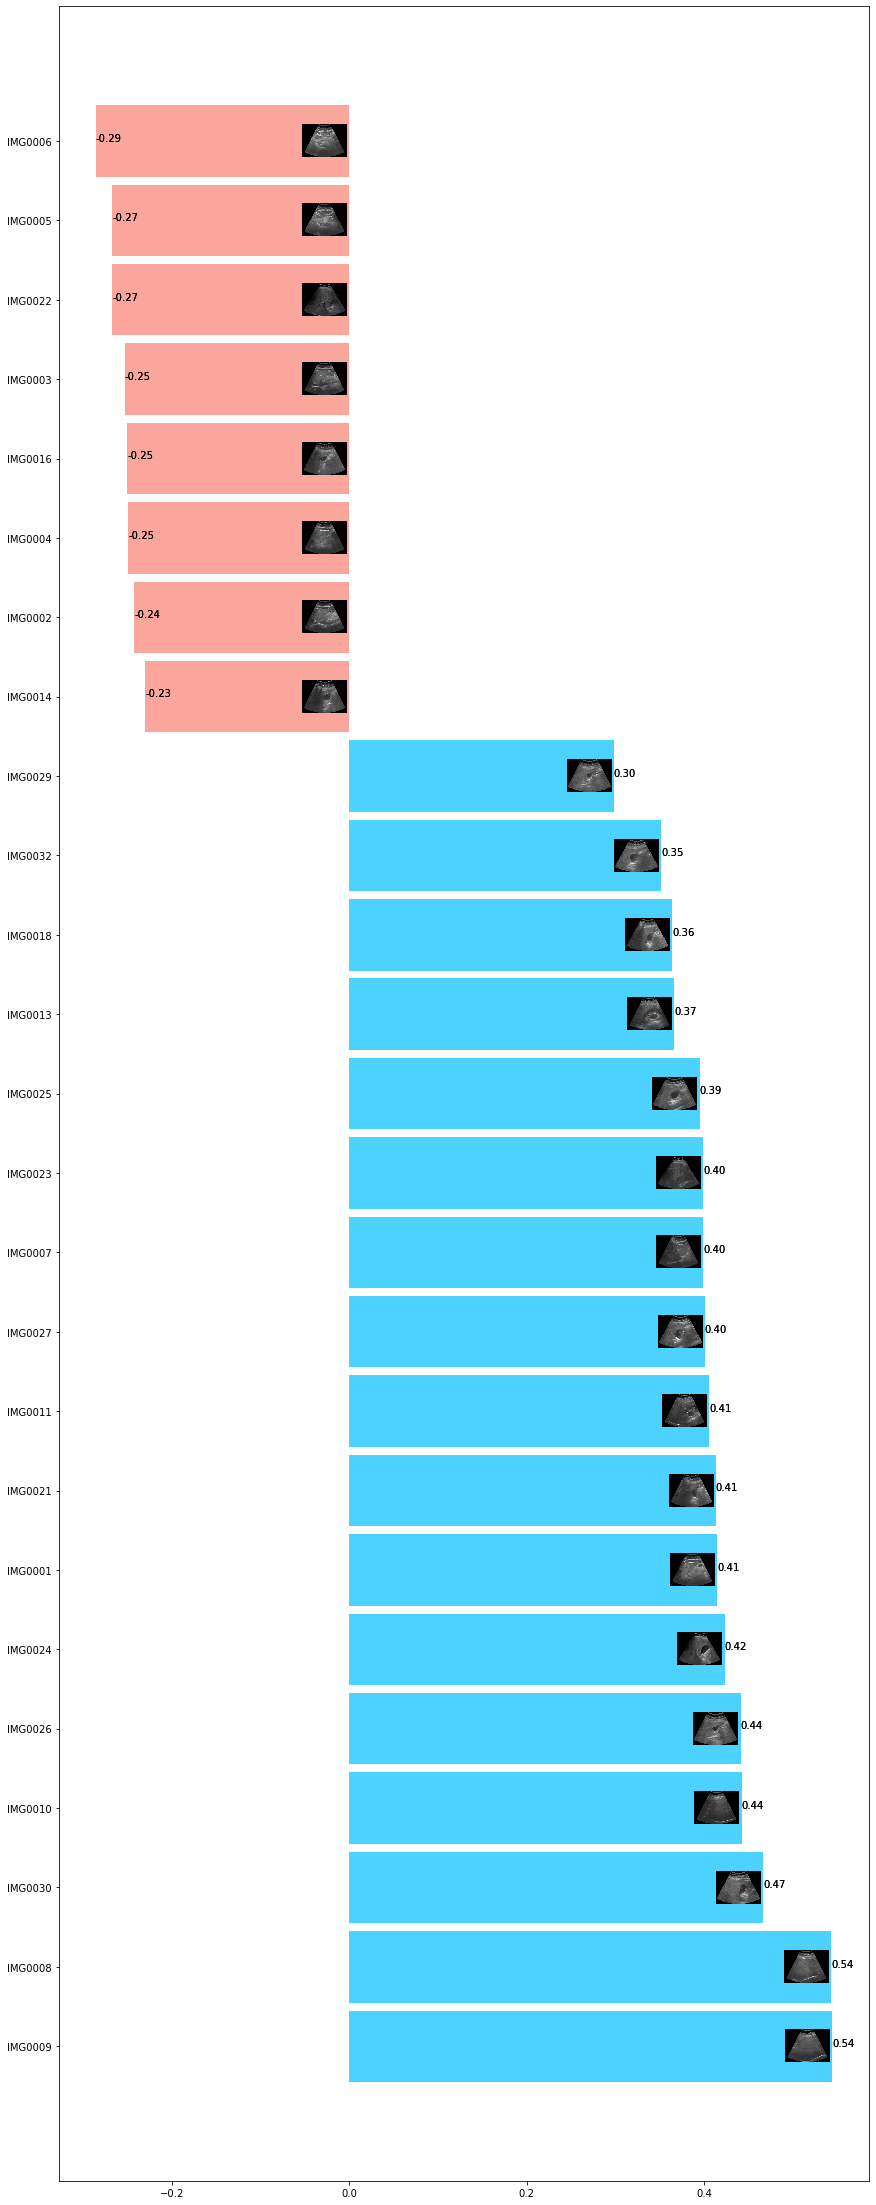

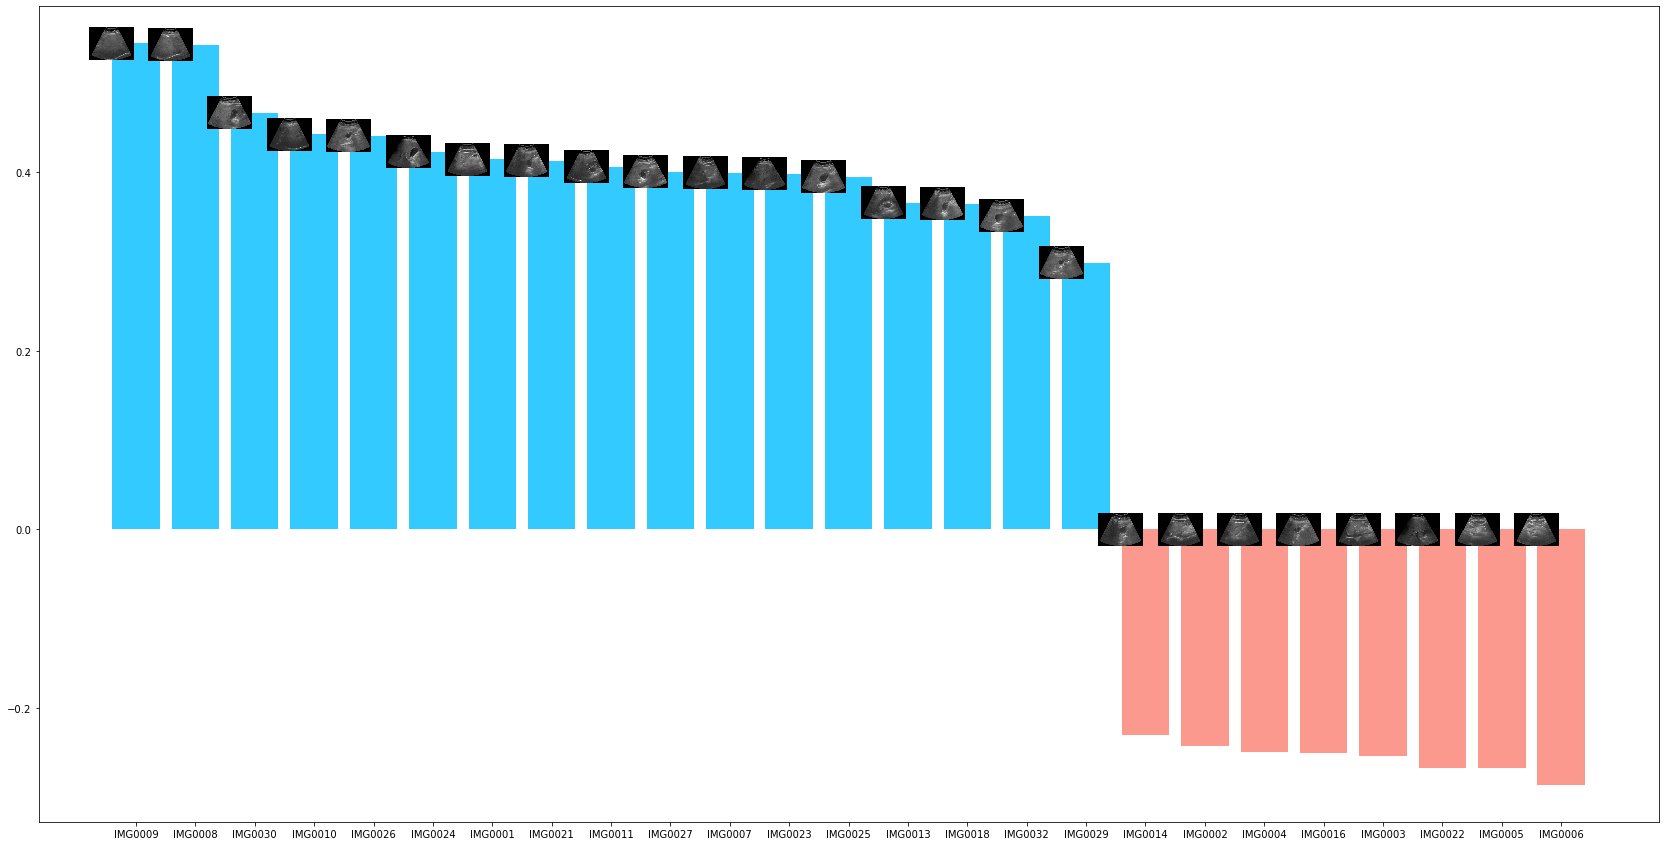

In [11]:
samples_class.plot_image_bar_plot()

## All subjects together?

In [ ]:
from LIME_custom_pipeline import LIME_all_subj_pipeline
testing_09 = LIME_all_subj_pipeline(
    test_data_id = '09', 
    # result_dir = "/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results",
)
testing_09.get_marginal_relations_of_all_subj()